<a href="https://colab.research.google.com/github/progManu/Advanced-Topics-Machine-Learning/blob/main/AdvML_Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Challenge 2*: *Discovering **Symmetries** in Data*

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Generate a dataset composed by rotations of 2-dimensional vectors *w.r.t.* a finite subgroup of the rotation group (*e.g.* every 3-4 degrees). Shuffle the dataset.  
Generate the labels according to the orbits.  

Implement a *NN* with one *FC* layer and `ReLU` to classify the orbits elements according to the label.  

Write a Loss that contains 3 terms:
- The regularization term as explained in class using [*soft-sort*](https://github.com/google-research/fast-soft-sort) on rows and columns of the Gramian of the first layer weights;
- The cross entropy entropy with orbit labels;
- The norm of the commutator between the covariance matrix of the data and that of the weights, as explained in class.  

We are encouraged to come up with other constraints instead of *1* and especially *3*.  

Test the invariance of the representation and plot the Gramian of the learned weights. Which type of matrix should you see?  

In [ ]:
import scipy as sp
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
!git clone --recursive https://github.com/google-research/fast-soft-sort.git
%cd /content/fast-soft-sort
from fast_soft_sort.pytorch_ops import soft_rank, soft_sort

fatal: destination path 'fast-soft-sort' already exists and is not an empty directory.
/content/fast-soft-sort


In [ ]:
# SOFTSORT TEST

values = torch.tensor([[5., 1., 2.], [2., 1., 5.]])
print(f'{values}')
print(f'{torch.roll(values, -1, 0)}')

soft_sort(values[:, (0, 1, 2)], regularization_strength=0.1)

tensor([[5., 1., 2.],
        [2., 1., 5.]])
tensor([[2., 1., 5.],
        [5., 1., 2.]])


tensor([[1., 2., 5.],
        [1., 2., 5.]], dtype=torch.float64)

In [ ]:
angles = np.linspace(-sp.pi, sp.pi, num=120) # define numeber of angles to roate with

In [ ]:
x = np.linspace(1, 10, num=10) # number of points are the number of classes
y = x

x = x.reshape(1, x.shape[0])
y = y.reshape(1, y.shape[0])

points = np.concatenate((x, y), axis=0)
points.shape

(2, 10)

x shape: (2, 1200), y shape: (2, 1200)


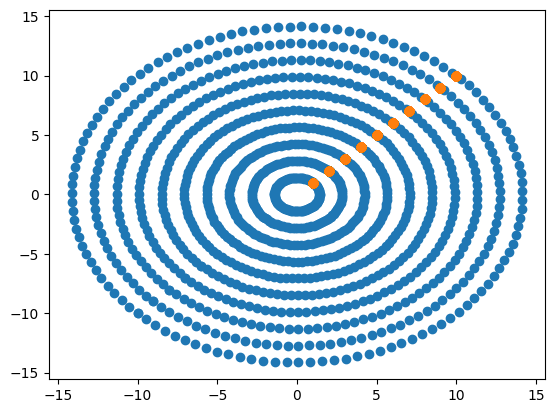

In [ ]:
x = np.array([[0], [0]])
y = np.array([[0], [0]])

for i in range(points.shape[1]):
  for theta in angles:
    rot_matrix = np.array(((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta))))
    rotated_vector = np.matmul(rot_matrix, points[:, i])
    rotated_vector = rotated_vector.reshape(rotated_vector.shape[0], 1)
    x = np.concatenate((x, rotated_vector), axis=1)
    y = np.concatenate((y, points[:, i].reshape(points[:, i].shape[0], 1)), axis=1)

x = np.delete(x, 0, axis=1)
y = np.delete(y, 0, axis=1)

print(f'x shape: {x.shape}, y shape: {y.shape}')

plt.scatter(x[0, :], x[1, :])
plt.scatter(y[0, :], y[1, :])
plt.show()

In [ ]:
class OrbitsDataset(Dataset):
    def __init__(self, src_data):
        self.src_data = src_data

    def __len__(self):
        return self.src_data[0].size()[0]

    def __getitem__(self, idx):
        return (self.src_data[0][idx, :], self.src_data[1][idx, :])

In [ ]:
temp_x = torch.tensor(x)
temp_y = torch.tensor(y).int()

print(temp_x[:, 0:3])
print(temp_y[:, 0:3])

tensor([[-1.0000, -0.9458, -0.8890],
        [-1.0000, -1.0514, -1.0998]], dtype=torch.float64)
tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int32)


In [ ]:
temp_x = torch.tensor(x)
temp_y = torch.tensor(y).int()

temp_x = temp_x.transpose(0, 1)
temp_y = temp_y.transpose(0, 1)

print(temp_x[0:3, :])
print(temp_y[0:3, :])

_, idxs = torch.unique(temp_y, return_inverse=True, dim=0)

data_in = temp_x
labels = torch.nn.functional.one_hot(idxs)

dataset = OrbitsDataset((data_in, labels))

tensor([[-1.0000, -1.0000],
        [-0.9458, -1.0514],
        [-0.8890, -1.0998]], dtype=torch.float64)
tensor([[1, 1],
        [1, 1],
        [1, 1]], dtype=torch.int32)


In [ ]:
S_BATCH_SIZE = 100 # batch size must be equal to the number of outputs

DATASET_LENGTH = len(dataset)

print(f'dataset len: {DATASET_LENGTH}')

TRAINING_RATIO = 0.7

TRAINING_SAMPLES_NUMBER = int(TRAINING_RATIO*DATASET_LENGTH)
TESTING_SAMPLES_NUMBER = DATASET_LENGTH - TRAINING_SAMPLES_NUMBER

print(f'train len: {TRAINING_SAMPLES_NUMBER}, test len: {TESTING_SAMPLES_NUMBER}')

trainset, testset = random_split(dataset, (TRAINING_SAMPLES_NUMBER, TESTING_SAMPLES_NUMBER))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=S_BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=S_BATCH_SIZE, shuffle=False)

dataset len: 1200
train len: 840, test len: 360


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class FCN(torch.nn.Module):
  def __init__(self):
    super(FCN, self).__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(2, 30), # 2 is input e 10 è numero di orbite
        torch.nn.ReLU(),
        torch.nn.Linear(30, 10),
        torch.nn.ReLU()
    )
  def forward(self, x):
    x = x.float()
    x = self.layers(x)
    return x

fcn = FCN().to(device)

In [ ]:
def gram_inv_reg_cols(gramian): # (TODO): iterare n^2 e non solo sigole distanze

  # operate on traspose to switch cols and rows because soft_sort operates on row and not cols
  gramian = gramian.cpu()
  sorted_gramian = soft_sort(gramian.transpose(0, 1), regularization_strength=0.1) 
 

  sorted_gramian = sorted_gramian.transpose(0,1).cpu()

  shifted_gramian = torch.roll(gramian, -1, 1).cpu()
  shifted_sorted_gramian = soft_sort(shifted_gramian.transpose(0,1), regularization_strength=0.1)
  shifted_sorted_gramian = shifted_sorted_gramian.transpose(0,1)

  return (torch.norm(sorted_gramian - shifted_sorted_gramian, p=2, dim=0)**2).to(device)

In [ ]:
def gram_inv_reg_rows(gramian):
  # operate on traspose to switch cols and rows because soft_sort operates on row and not cols
  gramian = gramian.cpu()
  sorted_gramian = soft_sort(gramian, regularization_strength=0.1)

  shifted_gramian = torch.roll(gramian, -1, 0).cpu()
  shifted_sorted_gramian = soft_sort(shifted_gramian, regularization_strength=0.1)

  return (torch.norm(sorted_gramian - shifted_sorted_gramian, p=2, dim=1)**2).to(device)

In [ ]:
def commutator_regularizer(gramian, x):
  X = torch.matmul(x, x.transpose(0,1))

  X = X.float()

  # print(f'x: {X.dtype}, gramian: {gramian.dtype}')

  commutator = torch.matmul(gramian, X) - torch.matmul(X, gramian)

  return torch.linalg.matrix_norm(commutator)**2

In [ ]:
loss = torch.nn.CrossEntropyLoss() # non sono sicuro della loss e della dimensione delle uscite della rete
optim = torch.optim.Adam(fcn.parameters(), lr=1e-3)

In [ ]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            y = y.nonzero(as_tuple=True)[1] # to get the index of the one hot encoding
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [ ]:
loss_list = []

def train(model, optimizer, trainloader, testloader):
    g_reg_term = 0.1
    epochs=1500
    for epoch in range(epochs):
        current_loss = []
        test_accuracy =  get_accuracy(model, testloader)
        model.train()
        train_loop = tqdm(trainloader, leave=False)
        for _, (x, y) in enumerate(train_loop):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            y = y.float()

            weigths = model.layers[0].weight
            gramian = torch.matmul(weigths, torch.transpose(weigths, 0, 1))

            l=loss(out, y) + g_reg_term*gram_inv_reg_cols(gramian).sum() # + g_reg_term*commutator_regularizer(gramian, x)
            # in realtà dei primi due regolarizzatori basta solo uno dei due in quanto il gramiano è simmetrico

            train_loop.set_description(f'Epoch [{epoch}/{epochs}]')
            train_loop.set_postfix(loss=l, acc=test_accuracy)

            current_loss.append(l)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        avg_loss = torch.tensor(current_loss).mean()
        loss_list.append(avg_loss)

In [ ]:
train(fcn, optim, trainloader, testloader)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([40, 2])


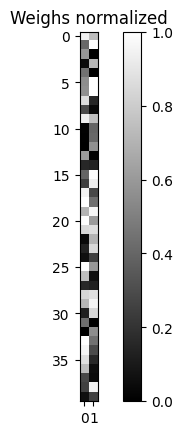

In [ ]:
weights = fcn.layers[0].weight.detach().cpu()

print(weights.size())

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)

# Plot
plt_weights = plt_weights.reshape(30, 2)

plt.imshow(plt_weights, cmap='gray')
plt.colorbar()
plt.title('Weighs normalized')
plt.show()

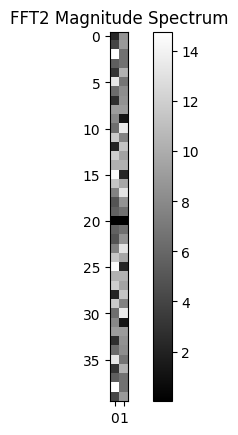

In [ ]:
plt_weights_fft = fcn.layers[0].weight.detach().cpu().numpy()

fft_image = np.fft.fft2(plt_weights_fft)
# Shift the zero frequency component to the center of the spectrum
fft_image_shifted = np.fft.fftshift(fft_image)

# Calculate the magnitude spectrum
magnitude_spectrum = np.abs(fft_image_shifted)

# Display the magnitude spectrum
plt.imshow(magnitude_spectrum, cmap='gray')
plt.colorbar()
plt.title('FFT2 Magnitude Spectrum')
plt.show()

In [ ]:
get_accuracy(fcn, testloader)

tensor(0.7988, device='cuda:0')

torch.Size([40])
torch.Size([40])


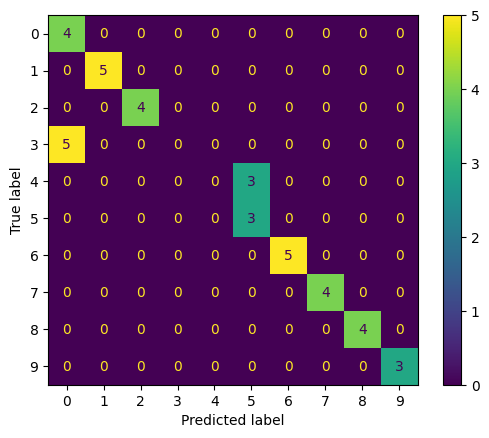

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

input, output = next(iter(testloader))

input = input.to(device)

model_out = fcn(input).detach().cpu()

output = output.cpu()

idx_model_out = torch.argmax(model_out, dim=1)
idx_output = torch.argmax(output, dim=1)

print(idx_model_out.size())
print(idx_output.size())

numpy_model_out = idx_model_out.numpy()
numpy_output = idx_output.numpy()

confusion_matrix = confusion_matrix(numpy_output, numpy_model_out)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [*range(10)])

cm_display.plot()
plt.show()